# APLICACIONES EN CIENCIAS DE COMPUTACION
Dr. Edwin Villanueva

## Algoritmo genetico para resolver el problema de las n reinas




<b>Clase abstracta de un individuo de algoritmo genético</b>

In [10]:
class Individual:
    "Clase abstracta para individuos de un algoritmo evolutivo."

    def __init__(self, chromosome):
        self.chromosome = chromosome

    def crossover(self, other):
        "Retorna un nuevo individuo cruzando self y other."
        raise NotImplementedError
        
    def mutate(self):
        "Cambia los valores de algunos genes."
        raise NotImplementedError        

<b>Clase concreta de un individuo del problema de las n-reinas</b>

In [11]:
import random

class Individual_nqueens(Individual):
    "Clase que implementa el individuo en el problema de las n-reinas."

    def __init__(self, chromosome):
        self.chromosome = chromosome[:]
        self.fitness = -1

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual_nqueens(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual_nqueens(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual_nqueens(chromosome1)
        ind2 = Individual_nqueens(chromosome2)
        return [ind1, ind2]     

    def mutate_position(self):
        "Cambia aleatoriamente la posicion de una reina."
        mutated_ind = Individual_nqueens(self.chromosome[:])
        indexPos = random.randint(0, len(mutated_ind.chromosome)-1)
        newPos = random.randint(0, len(mutated_ind.chromosome)-1)
        mutated_ind.chromosome[indexPos] = newPos
        return mutated_ind
    

<b>Funcion de fitness para evaluar un individuo del problema de las n-reinas</b>

In [12]:
def fitness_nqueens(chromosome):
    """Retorna el fitness de un cromosoma en el problema de las n-reinas (nro de pares de reinas no atacadas) """
    n = len(chromosome)  # nro de reinas
    fitness = 0
    for i in range(n-1):
        for j in range(i+1, n):
            # si el par de reinas i, j  no etan en la misma fila o diagonales => par no atacado
            if chromosome[j] not in [chromosome[i], chromosome[i] - (j-i),  chromosome[i] + (j-i)]:
                fitness = fitness + 1
    return fitness

<b>Funcion para evaluar toda una población de individuos con la funcion de fitnes especificada</b>

In [13]:
def evaluate_population(population, fitness_fn):
    """ Evalua una poblacion de individuos con la funcion de fitness pasada """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # si el individuo no esta evaluado
            population[i].fitness = fitness_fn(population[i].chromosome)

<b>Funcion que selecciona con el metodo de la ruleta un par de individuos de population para cruzamiento </b>

In [14]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
     
    # Escoje el segundo padre, desconsiderando el padre ya escogido
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

<b>Funcion que selecciona sobrevivientes para la sgte generacion, dada la poblacion actual y poblacion de hijos </b>

In [15]:
def select_survivors(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors): next_population.append(population[isurvivors[i]])
    return next_population

<b>Algoritmo Genetico</b>   
Recibe una poblacion inicial, funcion de fitness, numero de generaciones (ngen) y taza de mutación (pmut)

In [16]:
def genetic_algorithm(population, fitness_fn, ngen=100, pmut=0.1):
    "Algoritmo Genetico "
    
    popsize = len(population)
    evaluate_population(population, fitness_fn)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
    bestfitness = [population[ibest[0]].fitness]
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion
        
        ## Selecciona las parejas de padres para cruzamiento 
        mating_pool = []
        for i in range(int(popsize/2)): mating_pool.append(select_parents_roulette(population)) 
        
        ## Crea la poblacion descendencia cruzando las parejas del mating pool con Recombinación de 1 punto
        offspring_population = []
        for i in range(len(mating_pool)): 
            #offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) )
            offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) )

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                offspring_population[i] = offspring_population[i].mutate_position()
        
        ## Evalua la poblacion descendencia
        evaluate_population(offspring_population, fitness_fn)  # evalua la poblacion inicial
        
        ## Selecciona popsize individuos para la sgte. generación de la union de la pob. actual y  pob. descendencia
        population = select_survivors(population, offspring_population, popsize)

        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        print("generacion {}, best_fitness = {}".format(g, population[ibest[0]].fitness))
    
    return population[ibest[0]], bestfitness  

 <b>Algoritmo de Busqueda Genetica para el problema de las n-reinas</b>   

In [17]:
def genetic_search_nqueens(fitness_fn, num_queens=10, popsize=10, ngen=100, pmut=0.5):
    import random
    population = []

    ## Crea la poblacion inicial con cromosomas aleatorios
    for i in range(popsize):
        chromosome = [j for j in range(1,num_queens+1)]
        random.shuffle(chromosome)
        population.append( Individual_nqueens(chromosome) )
        
    ## Crea la poblacion inicial con los siguientes cromosomas    
    #chromosomes = [[1,3,1,3,1,3,1,3,1,3],
    #               [2,4,2,4,2,4,2,4,2,4],
    #               [3,5,3,5,3,5,3,5,3,5],
    #               [4,6,4,6,4,6,4,6,4,6],
    #               [5,7,5,7,5,7,5,7,5,7],
    #               [6,8,6,8,6,8,6,8,6,8],
    #               [7,9,7,9,7,9,7,9,7,9],
    #               [8,10,8,10,8,10,8,10,8,10],
    #               [9,1,9,1,9,1,9,1,9,1],
    #               [10,2,10,2,10,2,10,2,10,2] ]   
    #for i in range(popsize):
    #    population.append( Individual_nqueens(chromosomes[i]) )   
        
    ## llama al algoritmo genetico para encontrar una solucion al problema de las n reinas
    return genetic_algorithm(population, fitness_fn, ngen, pmut)
        

# Probando el Algoritmo genetico

Poblacion inicial, best_fitness = 43
generacion 0, best_fitness = 43
generacion 1, best_fitness = 43
generacion 2, best_fitness = 43
generacion 3, best_fitness = 43
generacion 4, best_fitness = 43
generacion 5, best_fitness = 44
generacion 6, best_fitness = 44
generacion 7, best_fitness = 44
generacion 8, best_fitness = 44
generacion 9, best_fitness = 44
generacion 10, best_fitness = 44
generacion 11, best_fitness = 44
generacion 12, best_fitness = 44
generacion 13, best_fitness = 44
generacion 14, best_fitness = 44
generacion 15, best_fitness = 44
generacion 16, best_fitness = 44
generacion 17, best_fitness = 44
generacion 18, best_fitness = 44
generacion 19, best_fitness = 44
generacion 20, best_fitness = 44
generacion 21, best_fitness = 44
generacion 22, best_fitness = 44
generacion 23, best_fitness = 44
generacion 24, best_fitness = 44
generacion 25, best_fitness = 44
generacion 26, best_fitness = 44
generacion 27, best_fitness = 44
generacion 28, best_fitness = 44
generacion 29, b

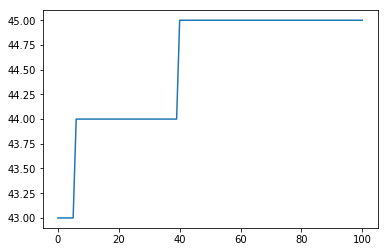

In [20]:
import matplotlib.pyplot as plt

# busca solucion para el problema de 10 reinas. Usa 100 individuos aleatorios, 100 generaciones y taza de mutación de 0.5
best_ind, bestfitness = genetic_search_nqueens(fitness_nqueens, 10, 100, 100, 0.90)
plt.plot(bestfitness)
plt.show()